In [1]:
!pip install gdown

In [2]:
!gdown --id 0BxYys69jI14kYVM3aVhKS1VhRUk

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
100% 107M/107M [00:00<00:00, 207MB/s] 


In [3]:
!tar -xf UTKFace.tar.gz

In [4]:
!pip install wandb

In [5]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, Dataset
from tqdm import tqdm
import wandb

In [6]:
wandb.init(project="age_regression_byFace")

wandb: Currently logged in as: alignb (use `wandb login --relogin` to force relogin)


In [7]:
batch_size = 64
epochs = 20
config = wandb.config
config.learning_rate = 0.001
width = height = 224

In [8]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('UTKFace')[0: 15000]:
    parts = image_name.split('_')
    ages.append(int(parts[0]))
    
    image = cv2.imread(f'UTKFace/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

df = pd.concat([images, ages], axis=1)
df.head()

,Images,Ages
0,"[[[28, 21, 15], [27, 20, 14], [25, 18, 12], [2...",35
1,"[[[8, 8, 8], [8, 8, 8], [9, 9, 9], [8, 8, 8], ...",36
2,"[[[157, 121, 71], [159, 123, 73], [162, 126, 7...",2
3,"[[[10, 14, 13], [9, 13, 12], [9, 13, 12], [8, ...",34
4,"[[[252, 255, 255], [254, 255, 255], [255, 255,...",10


35
(200, 200, 3)


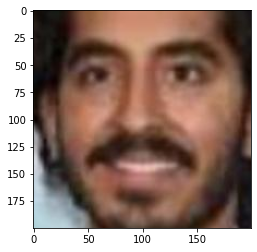

In [9]:
print(df['Ages'][0])
plt.imshow(df['Images'][0])
print(df['Images'][0].shape)

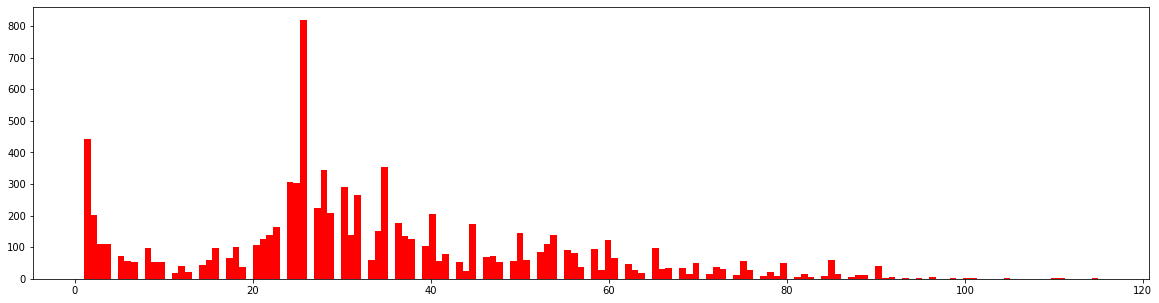

In [10]:
plt.figure(figsize=(20, 5))
plt.hist(df['Ages'], bins=150, color='red')
plt.show()

In [11]:
under_4 = []

for i in range(len(df)):
  if df['Ages'].iloc[i] <= 4:
    under_4.append(df.iloc[i])

under_4 = pd.DataFrame(under_4)
under_4 = under_4.sample(frac=0.3)

up_4 = df[df['Ages'] > 4]

df = pd.concat([under_4, up_4])

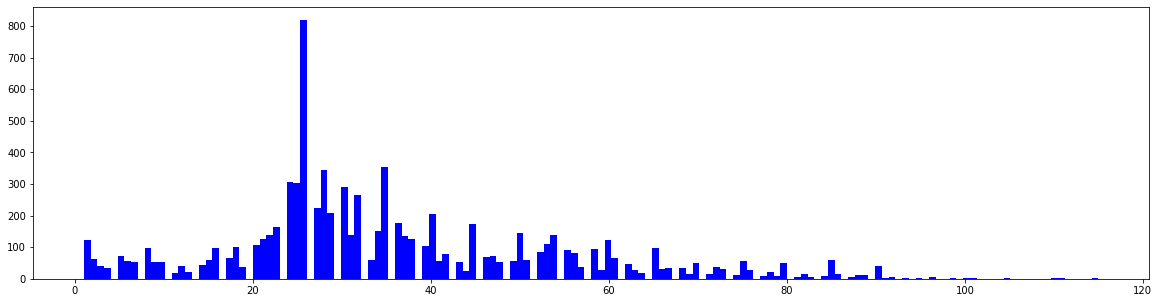

In [12]:
plt.figure(figsize=(20, 5))
plt.hist(df['Ages'], bins=150, color='blue')
plt.show()

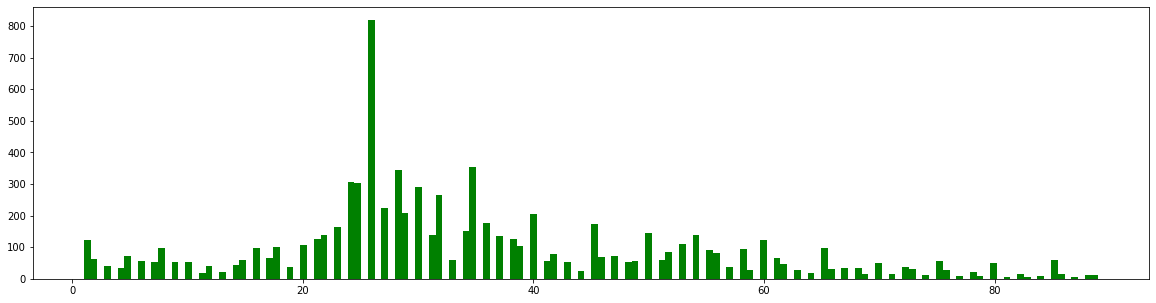

In [13]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(20, 5))
plt.hist(df['Ages'], bins=150, color='green')
plt.show()

In [14]:
X = []
Y =[]

for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

X = X.reshape((-1, X.shape[3], X.shape[1], X.shape[2]))
Y = Y.reshape(Y.shape[0], 1)
print(X.shape, Y.shape,X[0].shape)

X = torch.tensor(X)
Y = torch.tensor(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(8320, 3, 224, 224) (8320, 1) (3, 224, 224)


In [15]:
class CustomTensorDataset(Dataset):

    def __init__(self, tensors, transform):

        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)



transform = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])


train_dataset = CustomTensorDataset(tensors=(X, Y), transform=transform)

In [16]:
torch.manual_seed(0)

train_dataset_size = int(0.8 * len(train_dataset))
test_dataset_size = len(train_dataset) - train_dataset_size

train_data, _ = torch.utils.data.random_split(train_dataset, [train_dataset_size, test_dataset_size])
train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [17]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, (3, 3), (1, 1), (1, 1)) 
    self.conv2 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
    self.conv3 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))
    self.conv4 = nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1))
    self.conv5 = nn.Conv2d(256, 512, (3, 3), (1, 1), (1, 1))

    self.fc1 = nn.Linear(512*7*7 ,256)
    self.fc2 = nn.Linear(256 ,128)
    self.fc3 = nn.Linear(128 ,64)
    self.fc4 = nn.Linear(64, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))

    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))

    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))

    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))

    x = torch.flatten(x, start_dim=1)
    x = torch.dropout(x, 0.2, train=True)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    output = self.fc4(x)

    return output

In [19]:
# args.gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() and args.gpu else "cpu")
model = Model().to(device)
wandb.watch(model)

[]

In [20]:
# compile

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
loss_function = nn.L1Loss()

In [21]:
# train

model.train()

for e in range(epochs):
  train_loss = 0.0
  train_acc = 0.0
  for images, labels in tqdm(train_data):

    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    images = images.float()
    preds = model(images)

    loss = loss_function(preds,  labels.float())
    loss.backward()

    optimizer.step()

    train_loss += loss

  total_loss = train_loss / len(train_data)
  print(f"Epoch: {e+1}, Loss: {total_loss}")

  wandb.log({'epochs':  e + 1,'loss': total_loss,})

100%|██████████| 104/104 [00:39<00:00,  2.64it/s]


Epoch: 1, Loss: 20.417373657226562


100%|██████████| 104/104 [00:39<00:00,  2.65it/s]


Epoch: 2, Loss: 13.88752555847168


100%|██████████| 104/104 [00:38<00:00,  2.68it/s]


Epoch: 3, Loss: 13.353217124938965


100%|██████████| 104/104 [00:39<00:00,  2.66it/s]


Epoch: 4, Loss: 12.913007736206055


100%|██████████| 104/104 [00:38<00:00,  2.68it/s]


Epoch: 5, Loss: 13.007226943969727


100%|██████████| 104/104 [00:38<00:00,  2.68it/s]


Epoch: 6, Loss: 12.783746719360352


100%|██████████| 104/104 [00:39<00:00,  2.67it/s]


Epoch: 7, Loss: 12.667997360229492


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 8, Loss: 12.508432388305664


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 9, Loss: 12.4520263671875


100%|██████████| 104/104 [00:39<00:00,  2.66it/s]


Epoch: 10, Loss: 12.387188911437988


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 11, Loss: 12.384747505187988


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 12, Loss: 12.078413009643555


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 13, Loss: 12.251622200012207


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 14, Loss: 11.957955360412598


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 15, Loss: 12.066072463989258


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 16, Loss: 11.532912254333496


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 17, Loss: 11.72685718536377


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 18, Loss: 11.719095230102539


100%|██████████| 104/104 [00:38<00:00,  2.67it/s]


Epoch: 19, Loss: 11.668898582458496


100%|██████████| 104/104 [00:39<00:00,  2.66it/s]


Epoch: 20, Loss: 11.631559371948242


In [22]:
torch.save(model.state_dict(), "age_prediction.pth")